## Environment Setting - Setting up everything!

**In this notebook, we will...**

1. Generate a requirements file `requirements.txt` and install all required packages
2. Import Python modules and custom modules developed by me and keeped in `/src`
3. Test that custom modules using some example dataset

**How interpret object and variables names?**

- Objects and variables that your names starts with `_` indicates a temporary object. This object can be alterated is distinct contexts or can be deleted after being used. 


---

### <a id='index'>Table of Contents</a>

#### [1. Environment Settings](#sec_1)
#### [2. Pratice DataSet](#sec_2)
#### [3. Model Development (extremely symplified)](#sec_3)
##### [3.1. Model Metrics](#sec_31)
---


## Draft - TO_DO List

- [X] Getting some kaggle dataset
- [ ] Class for bootstrap metrics
- [ ] Class for validation plots with confidence intervals

### <a id='sec_1'>1. Environment Settings </a>


[Return to Index](#index)

In [1]:
import subprocess
import sys

_requirements = """#Python 3.11.4
pandas==2.0
numpy>=1.21.0, <1.27.0, !=1.24.0
scipy==1.10
scikit-learn==1.3
matplotlib==3.7
seaborn==0.12.2
lightgbm==4.1.0
shap==0.42.1
tqdm
"""
with open('requirements.txt', 'w') as _f:
    _f.write(_requirements)

subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "pip"])
subprocess.check_call([sys.executable, "-m", "pip", "install", "-r", "requirements.txt"])

del(_requirements)
del(subprocess)
del(sys)
del(_f)

In [2]:
# Python Modules
import pandas as pd
import numpy as np
import shap

from lightgbm import LGBMClassifier

from tqdm import tqdm

from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score

# Custom modules

# Pandas display settings
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

# Constants 
RND_SEED = 42

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


### <a id='sec_2'>2. Pratice DataSet </a>

**Dataset Reference:**

- [Sloan Digital Sky Survey - DR18](https://www.kaggle.com/datasets/diraf0/sloan-digital-sky-survey-dr18) (From Kaggle)

[Return to Index](#index)

In [3]:
# Note: 'field' also can be interpreted as an id, but this variable carring 
# ----- this variable carring the informatiou about the sky position of
#       objects - Looking at the description:
#       "The entire sky is divided into a portion of fields and the field 
#        number column refers to the field or portion of the sky from 
#        which an observation was obtained."
#       Because of this, I decided to keep this information as a feature, not 
#       an id. 
#       
#       Equivalent intuition are present in the columns 'camcol', 'run', 'rerun'
#       and 'plate' - I'll test them to decide if I'll use as feature.


# ---
# Specifying the lists of columns to be used

# IDs
id_columns = ['Objid', 'Specobjid', 'fiberID']

# 'class' can assume the labels: 'STAR', 'GALAXY' and 'QSO' 
# (Quasi-Stellar Object or a Quasar)
target_column = ['class']

# 'mjd' - Modified Julian Date represents the number of days that have passed 
#         since midnight Nov. 17, 1858. It is used in SDSS to keep track of 
#         the time of each observation. 
time_columns = ['mjd']

# Columns described as features
# feature_columms = ['ra', 'dec', 'redshift', 'u', 'g', 'r', 'i', 'z', 
#                    'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 
#                    'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_r',
#                    'petroFlux_i', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 
#                    'petroR50_r', 'petroR50_i', 'petroR50_z', 'psfMag_u', 
#                    'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'expAB_u', 
#                    'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z']

feature_columms = ['ra', 'dec', 'u', 'g', 'r', 'i', 'z', 
                   'petroRad_u', 'petroRad_g', 'petroRad_r', 'petroRad_i', 
                   'petroRad_z', 'petroFlux_u', 'petroFlux_g', 'petroFlux_r',
                   'petroFlux_i', 'petroFlux_z', 'petroR50_u', 'petroR50_g', 
                   'petroR50_r', 'petroR50_i', 'petroR50_z', 'psfMag_u', 
                   'psfMag_g', 'psfMag_r', 'psfMag_i', 'psfMag_z', 'expAB_u', 
                   'expAB_g', 'expAB_r', 'expAB_i', 'expAB_z']

# These below will be tested in order to discover what of them I can 
# use as feature:
maybe_feature_coluns = ['camcol', 'run', 'rerun', 'field', 'plate']

# ---
# Reading the data and print informations
raw_df = pd.read_csv('data/SDSS_DR18.csv')

print('----------------------------')
print('  Raw Dataset Informations: ')
print('----------------------------')
print(f"#Rows: {raw_df.shape[0]} | #Columns: {raw_df.shape[1]} ")
print('----------------------------')
print('')
print('----------------------------')
print('Target - Label Proportions:')
print('----------------------------')
print(raw_df[target_column].value_counts() / raw_df.shape[0])
print('----------------------------')

----------------------------
  Raw Dataset Informations: 
----------------------------
#Rows: 100000 | #Columns: 43 
----------------------------

----------------------------
Target - Label Proportions:
----------------------------
class 
GALAXY    0.52343
STAR      0.37232
QSO       0.10425
Name: count, dtype: float64
----------------------------


In [4]:
# Adjust target variable
_replacements = {
    'GALAXY': '0',
    'STAR': '1',
    'QSO': '2'
}

raw_df[target_column] = raw_df[target_column] \
                            .replace(_replacements) \
                            .astype(int)

# Remove temporary objects
del(_replacements)

Adding some noise (just for fun)

In [5]:
for _f in tqdm(feature_columms):
    raw_df[_f] = [_x * (1 + np.random.normal(loc=0.0, scale=1.0)) for _x in raw_df[_f]]

del(_f)

100%|██████████| 32/32 [00:04<00:00,  7.59it/s]


In [6]:
raw_df.head()

,objid,specobjid,ra,dec,u,g,r,i,z,run,rerun,camcol,field,plate,mjd,fiberid,petroRad_u,petroRad_g,petroRad_i,petroRad_r,petroRad_z,petroFlux_u,petroFlux_g,petroFlux_i,petroFlux_r,petroFlux_z,petroR50_u,petroR50_g,petroR50_i,petroR50_r,petroR50_z,psfMag_u,psfMag_r,psfMag_g,psfMag_i,psfMag_z,expAB_u,expAB_g,expAB_r,expAB_i,expAB_z,redshift,class
0,1.240000e+18,3.240000e+17,654.828149,0.442119,-6.971616,26.647946,33.304554,25.217579,22.548581,756,301,5,462,288,52000,456,13.467122,13.818520,15.413235,9.783112,14.456691,59.050418,130.357709,438.976112,310.976882,257.175968,10.709705,3.465409,4.628890,2.190705,3.565858,43.163454,18.971553,32.989751,8.407826,57.025631,0.427526,0.172027,0.284909,0.526590,0.958291,0.041691,0
1,1.240000e+18,3.250000e+17,85.062377,-0.266678,1.850808,13.686908,1.878623,-7.473086,-2.870165,756,301,5,467,289,51990,322,2.476804,0.026238,3.315163,1.943197,1.899901,26.257814,9.534216,-1.389343,6.457665,-0.169420,0.207135,1.067228,0.478591,1.594019,-0.235434,13.543565,15.414719,7.617185,10.436379,16.865282,0.694695,0.359012,0.233811,1.476477,0.411767,-0.000814,1
2,1.240000e+18,3.240000e+17,-125.508314,1.573015,2.334591,32.990618,20.684290,41.591400,26.415215,756,301,5,467,288,52000,614,4.739675,3.061875,7.200206,4.052170,2.656445,-20.034606,90.555343,289.175310,578.410569,364.601089,0.657806,4.159386,3.067231,1.018201,2.610210,1.108573,29.568453,48.285164,37.115676,10.590950,0.413348,0.248562,2.172214,0.449656,1.508650,0.113069,0
3,1.240000e+18,2.880000e+18,359.756756,1.171783,-12.490265,39.012425,18.978244,30.492216,18.370613,756,301,5,467,2558,54140,414,0.575518,1.116596,2.003511,2.455518,0.000255,32.965770,116.153411,72.881120,-140.091293,92.197067,0.803917,1.256288,0.717449,1.677227,0.206358,32.795810,-2.044414,9.284171,34.869780,-21.244234,1.379925,0.905654,-0.936079,0.753574,0.887086,0.000087,1
4,1.240000e+18,2.880000e+18,415.943062,0.547017,6.366479,27.959868,6.230998,5.227660,1.431530,756,301,5,467,2558,54140,403,1.063093,1.783254,-0.287812,1.345771,1.934594,51.647944,-36.124760,610.317453,537.192129,616.210202,-0.400852,1.592638,1.297898,0.997092,-0.099162,15.204861,30.989113,8.913269,27.356820,18.479905,1.631979,0.418278,1.154089,1.299102,0.762469,0.000018,1


**Splitting data into train and test**

Sample split stratified by target variable. Propotions:
- Train:      80%
- Validation: 20%

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    raw_df[feature_columms],
    raw_df[target_column],
    test_size=.2,
    stratify=raw_df[target_column],
    random_state=RND_SEED,
    shuffle=True
)

### <a id='sec_3'>3. Model Development (extremely symplified)</a>

Training of a LGBM algorithm in Multiclass classification set. Here we are just interested in have some model to work and validate the class and functions in development, because of this we won't work in any parameter optimization, feature engineering or something like that. 



[Return to Index](#index)

In [8]:
# ---
# Evaluate class weights 
_weights = compute_class_weight(class_weight='balanced', 
                                classes=np.unique(y_train),
                                y=y_train.values.reshape(-1))

dict_class_weights = dict(zip(np.unique(raw_df[target_column]), _weights))

# ---
# LGBMClassifier Setup
_params = {
    'objective': 'multiclass',
    'class_weight': dict_class_weights,
    'random_state': RND_SEED,
    'metric': 'multi_logloss'
}

# ---
# Eval Set
# eval_set = [(_x, _y) for _x, _y in zip(X_test, y_test)]
eval_set = [(X_test, y_test.values.reshape(-1))]

# ---
# Create model object and fit them
model = LGBMClassifier(**_params) \
            .fit(X_train, y_train.values.reshape(-1), eval_set=eval_set)

# ---
# Remove temporary objects
del(_weights)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008732 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 80000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [9]:
# Classifications Results

df_predictions = pd.concat([
    pd.DataFrame({
        'context': ['train' for _ in y_train.values],
        'target': [_y[0] for _y in y_train.values],
        'prediction': model.predict(X_train),
        'prediction_score': [np.max(_s) for _s in model.predict_proba(X_train)],
        'score_0': [_s[0] for _s in model.predict_proba(X_train)],
        'score_1': [_s[1] for _s in model.predict_proba(X_train)],
        'score_2': [_s[2] for _s in model.predict_proba(X_train)],
    }),
    pd.DataFrame({
        'context': ['validation' for _s in y_test.values],
        'target': [_y[0] for _y in y_test.values],
        'prediction': model.predict(X_test),
        'prediction_score': [np.max(_s) for _s in model.predict_proba(X_test)],
        'score_0': [_s[0] for _s in model.predict_proba(X_test)],
        'score_1': [_s[1] for _s in model.predict_proba(X_test)],
        'score_2': [_s[2] for _s in model.predict_proba(X_test)],
    }),
])

df_predictions.sample(n=30).head(30)

,context,target,prediction,prediction_score,score_0,score_1,score_2
12806,train,0,0,0.987908,0.987908,0.001515,0.010577
24114,train,2,2,0.941810,0.007598,0.050592,0.941810
47459,train,1,1,0.558401,0.124836,0.558401,0.316763
21624,train,1,1,0.816850,0.010311,0.816850,0.172839
2734,validation,1,1,0.966976,0.004191,0.966976,0.028833
29009,train,1,1,0.992019,0.001747,0.992019,0.006234
6319,validation,1,1,0.958760,0.007667,0.958760,0.033573
5807,train,1,2,0.562349,0.005588,0.432064,0.562349
50797,train,2,2,0.657057,0.004002,0.338941,0.657057
2479,validation,0,0,0.884650,0.884650,0.028485,0.086865


### <a id='sec_31'>3.1. Model Metrics</a>



[Return to Index](#index)

In [10]:
# One vs All
_context = 'validation'

_df_aux = df_predictions[df_predictions['context']==_context]

for _c in dict_class_weights.keys():
    _score = _df_aux['score_' + str(_c)].to_list()
    _y_pred = [1 if _p==_c else 0 for _p in _df_aux['prediction']]
    _y_true = [1 if _p==_c else 0 for _p in _df_aux['target']]

    _roc_auc = roc_auc_score(_y_true, _score)

    print(f"ROC_AUC Score for class {_c}:              {_roc_auc}")

print('----------------------------------------------------------')

# ROC-AUC: Train
_roc_auc = roc_auc_score(
    y_train.values,
    model.predict_proba(X_train), 
    multi_class='ovr',
    average="micro")

print(f"ROC_AUC Score (General - Train):        {_roc_auc}")

# ROC-AUC: Validation
_roc_auc = roc_auc_score(
    y_test.values,
    model.predict_proba(X_test), 
    multi_class='ovr',
    average="micro")

print(f"ROC_AUC Score (General - Validation):   {_roc_auc}")

ROC_AUC Score for class 0:              0.9892687454251247
ROC_AUC Score for class 1:              0.9783802626962561
ROC_AUC Score for class 2:              0.9333228923420015
----------------------------------------------------------
ROC_AUC Score (General - Train):        0.987335614140625
ROC_AUC Score (General - Validation):   0.9784488724999999


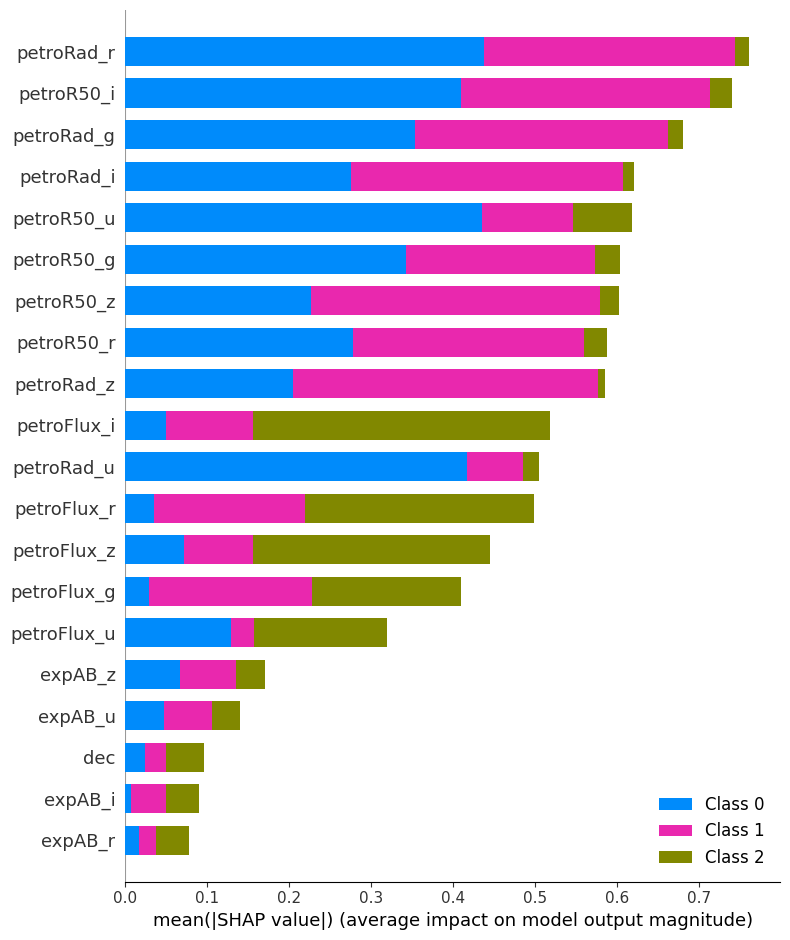

In [11]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)

shap.summary_plot(shap_values, X_train, feature_names=feature_columms)


### Bootstrap Metrics (remove after)

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score
from sklearn.metrics import precision_score, recall_score, log_loss
from sklearn.metrics import brier_score_loss, accuracy_score

from tqdm import tqdm


def get_classification_metrics(y_true, y_predicted, y_score):
    # Evaluate binary classification metrics (if multi-class, just evaluate
    # One vs Rest)
    if len(np.unique(y_true)) > 1:
        multi_class = 'ovr'
        metric_avg = 'micro'
    else:
        multi_class = 'raise'
        metric_avg = 'binary'

    return {
        'roc_auc_score': roc_auc_score(y_true, y_score, multi_class=multi_class),
        'gini_score': 2 * roc_auc_score(y_true, y_score, 
                                        multi_class=multi_class) - 1,
        'f1_score': f1_score(y_true, y_predicted, average=metric_avg),
        'average_precision_score': average_precision_score(y_true, y_score),
        'precision_score': precision_score(y_true, y_predicted, 
                                           average=metric_avg),
        'recall_score': recall_score(y_true, y_predicted, average=metric_avg),
        'log_loss': log_loss(y_true, y_score),
        # 'brier_score_loss': brier_score_loss(y_true, y_score),
        'accuracy_score': accuracy_score(y_true, y_predicted),
    }


# def get_bs_samples(X, y, bootstrap_samples):
#     return train_test_split(X, y, test_size= 1/bootstrap_samples)
def eval_bs_metrics(model_obj,
                    X,
                    y,
                    bootstrap_samples=5,
                    n_iteractions=1000):

    # y_classes = np.unique(y)

    df_metrics = pd.DataFrame(
        columns=['iteraction', 'roc_auc_score', 'gini_score', 'f1_score',
                 'average_precision_score', 'precision_score', 'recall_score',
                 'log_loss', 'accuracy_score']
    )

    for i in tqdm(range(n_iteractions)):
        # Evaluate BootStrap Samples:
        X_train, X_test, y_train, y_test = train_test_split(
            X, 
            y, 
            test_size= 1/bootstrap_samples,
            shuffle=True,
            stratify=y
            )
        
        model_obj.fit(X_train, y_train);

        y_predicted = model_obj.predict(X_test)
        y_score = model_obj.predict_proba(X_test)

        _metrics = get_classification_metrics(y_test, y_predicted, y_score)
        _metrics['iteraction'] = i

        df_metrics = pd.concat([
            df_metrics,
            pd.DataFrame(_metrics, index=[0])
        ])

    return df_metrics

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    raw_df[feature_columms],
    raw_df[target_column],
    test_size=.1,
    stratify=raw_df[target_column],
    random_state=RND_SEED,
    shuffle=True
)

# ---
# Evaluate class weights 
_weights = compute_class_weight(class_weight='balanced', 
                                classes=np.unique(y_train),
                                y=y_train.values.reshape(-1))

dict_class_weights = dict(zip(np.unique(raw_df[target_column]), _weights))

# ---
# Eval Set
eval_set = [(X_test, y_test.values.reshape(-1))]

# ---
# LGBMClassifier Setup
_params = {
    'objective': 'multiclass',
    'class_weight': dict_class_weights,
    'random_state': RND_SEED,
    'metric': 'multi_logloss',
}


# ---
# Create model object and fit them
model = LGBMClassifier(**_params) \
            .fit(X_train, y_train.values.reshape(-1), eval_set=eval_set)

# ---
# Remove temporary objects
del(_weights)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009869 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 90000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612
[LightGBM] [Info] Start training from score -1.098612


In [14]:
# eval_bs_metrics(model, X_train, y_train, n_iteractions=30)


In [15]:
# del(bootstrap) 

In [16]:
# Testing class

from src.bootstrap import bootstrap

metrics_df = bootstrap.eval_bs_metrics(model, X_train, y_train, n_iteractions=30)


  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008338 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


  3%|▎         | 1/30 [00:02<01:21,  2.81s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


  7%|▋         | 2/30 [00:05<01:13,  2.63s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 10%|█         | 3/30 [00:08<01:11,  2.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 13%|█▎        | 4/30 [00:10<01:07,  2.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008941 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 17%|█▋        | 5/30 [00:13<01:04,  2.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008672 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 20%|██        | 6/30 [00:15<01:04,  2.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009381 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 23%|██▎       | 7/30 [00:18<01:02,  2.71s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008249 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 27%|██▋       | 8/30 [00:21<00:58,  2.67s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008438 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 30%|███       | 9/30 [00:23<00:54,  2.60s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011266 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 33%|███▎      | 10/30 [00:26<00:53,  2.69s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008415 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 37%|███▋      | 11/30 [00:29<00:50,  2.68s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010517 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 40%|████      | 12/30 [00:31<00:47,  2.64s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 43%|████▎     | 13/30 [00:34<00:43,  2.57s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009138 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 47%|████▋     | 14/30 [00:36<00:40,  2.52s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008430 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 50%|█████     | 15/30 [00:38<00:37,  2.47s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008795 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 53%|█████▎    | 16/30 [00:41<00:34,  2.48s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008721 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 57%|█████▋    | 17/30 [00:43<00:31,  2.45s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010023 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 60%|██████    | 18/30 [00:46<00:31,  2.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 63%|██████▎   | 19/30 [00:49<00:29,  2.69s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 67%|██████▋   | 20/30 [00:52<00:27,  2.76s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 70%|███████   | 21/30 [00:55<00:24,  2.76s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009654 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 73%|███████▎  | 22/30 [00:58<00:21,  2.74s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011836 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 77%|███████▋  | 23/30 [01:01<00:19,  2.82s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010529 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 80%|████████  | 24/30 [01:04<00:17,  2.87s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 83%|████████▎ | 25/30 [01:06<00:14,  2.85s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009983 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 87%|████████▋ | 26/30 [01:10<00:12,  3.01s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001966 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 90%|█████████ | 27/30 [01:13<00:09,  3.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013441 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 93%|█████████▎| 28/30 [01:16<00:06,  3.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012250 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 97%|█████████▋| 29/30 [01:20<00:03,  3.36s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


100%|██████████| 30/30 [01:23<00:00,  2.79s/it]


In [17]:
metrics_df.head()

,iteraction,roc_auc_score,gini_score,f1_score,average_precision_score,precision_score,recall_score,log_loss,accuracy_score
0,0,0.967797,0.935595,0.899333,0.876834,0.899333,0.899333,0.268475,0.899333
0,1,0.971392,0.942785,0.901778,0.881613,0.901778,0.901778,0.264216,0.901778
0,2,0.970012,0.940024,0.903333,0.873018,0.903333,0.903333,0.268751,0.903333
0,3,0.970287,0.940573,0.903000,0.880696,0.903000,0.903000,0.268331,0.903000
0,4,0.966787,0.933574,0.900778,0.875171,0.900778,0.900778,0.276777,0.900778


In [19]:
%%time
metric_ci, metrics_df = bootstrap.get_metrics_ci(model, X_train, y_train,
                                          return_evaluations_df=True, 
                                          n_iteractions=30)


  0%|          | 0/30 [00:00<?, ?it/s]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007830 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


  3%|▎         | 1/30 [00:04<02:02,  4.24s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008162 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


  7%|▋         | 2/30 [00:06<01:27,  3.12s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008155 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 10%|█         | 3/30 [00:09<01:21,  3.03s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 13%|█▎        | 4/30 [00:12<01:14,  2.87s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008308 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 17%|█▋        | 5/30 [00:14<01:09,  2.76s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 20%|██        | 6/30 [00:17<01:02,  2.62s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 23%|██▎       | 7/30 [00:19<00:58,  2.53s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 27%|██▋       | 8/30 [00:21<00:56,  2.55s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008789 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 30%|███       | 9/30 [00:24<00:53,  2.55s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009879 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 33%|███▎      | 10/30 [00:26<00:50,  2.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 37%|███▋      | 11/30 [00:29<00:49,  2.58s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010076 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 40%|████      | 12/30 [00:32<00:45,  2.53s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015918 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 43%|████▎     | 13/30 [00:34<00:43,  2.58s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008948 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 47%|████▋     | 14/30 [00:37<00:40,  2.50s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011745 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 50%|█████     | 15/30 [00:40<00:39,  2.66s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 53%|█████▎    | 16/30 [00:42<00:36,  2.59s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 57%|█████▋    | 17/30 [00:44<00:32,  2.51s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007680 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 60%|██████    | 18/30 [00:46<00:28,  2.39s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011428 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 63%|██████▎   | 19/30 [00:49<00:28,  2.56s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011637 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 67%|██████▋   | 20/30 [00:52<00:26,  2.69s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009964 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 70%|███████   | 21/30 [00:55<00:24,  2.72s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 73%|███████▎  | 22/30 [00:58<00:22,  2.79s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011779 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 77%|███████▋  | 23/30 [01:01<00:19,  2.79s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015634 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 80%|████████  | 24/30 [01:04<00:17,  2.88s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009787 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 83%|████████▎ | 25/30 [01:07<00:15,  3.02s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009476 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 87%|████████▋ | 26/30 [01:10<00:11,  2.88s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010483 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 90%|█████████ | 27/30 [01:13<00:08,  2.80s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003975 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 93%|█████████▎| 28/30 [01:15<00:05,  2.80s/it]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010736 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


 97%|█████████▋| 29/30 [01:18<00:02,  2.75s/it]

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8160
[LightGBM] [Info] Number of data points in the train set: 81000, number of used features: 32
[LightGBM] [Info] Start training from score -1.098621
[LightGBM] [Info] Start training from score -1.098622
[LightGBM] [Info] Start training from score -1.098595


100%|██████████| 8/8 [00:00<00:00, 235.66it/s]

CPU times: user 4min 12s, sys: 5.57 s, total: 4min 17s
Wall time: 1min 21s


In [20]:
metric_ci

{'roc_auc_score': [(0.9681566691557197, 0.9693770573177618),
  0.9687668632367408,
  0.00029878191773009176],
 'gini_score': [(0.936313338311439, 0.9387541146355232),
  0.9375337264734811,
  0.0005975638354601835],
 'f1_score': [(0.8993173837150505, 0.901275208877542),
  0.9002962962962963,
  0.00047932516458583136],
 'average_precision_score': [(0.873580035209305, 0.877470513571651),
  0.875525274390478,
  0.0009524875954582295],
 'precision_score': [(0.8993173837150505, 0.901275208877542),
  0.9002962962962963,
  0.00047932516458583016],
 'recall_score': [(0.8993173837150505, 0.901275208877542),
  0.9002962962962963,
  0.00047932516458583016],
 'log_loss': [(0.2700112661706582, 0.27407141353339615),
  0.27204133985202716,
  0.0009940268621384815],
 'accuracy_score': [(0.8993173837150505, 0.901275208877542),
  0.9002962962962963,
  0.00047932516458583016],
 'format_description': [('lower_limit', 'upper_limit'), 'avg', 'std']}